In [37]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score
import joblib

# =========================
# CONFIG: Set features here
# =========================
FEATURES = [
    'Feature_Instab_Delta_occurrence_Var',
    'Feature_HubPLI_Beta_Frontal',
    'Feature_Instab_Delta_coverage_CV',
    'Feature_Theta_Asymmetry_Idx',
    'Feature_DWT_Theta_over_alpha_frac',
    'Feature_Gamma_Posterior_Abs',

]

# =========================
# LOAD DATA
# =========================
df = pd.read_csv("ML_Feature_Matrix.csv")
X = df[FEATURES].values
y = df['Label_Impaired'].values

# =========================
# MODEL CONFIG
# =========================
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=42)

metrics = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'BalancedAcc': make_scorer(balanced_accuracy_score)
}

# =========================
# BUILD PIPELINE
# =========================
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42))
])

# =========================
# CROSS-VALIDATED EVALUATION
# =========================
cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=metrics, return_train_score=False)

print("\n--- SVM Classification Performance ---")
for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        print(f"{metric_name[5:]}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# =========================
# TRAIN FINAL MODEL ON FULL DATA
# =========================
pipeline.fit(X, y)
joblib.dump(pipeline, "PD_MoCA_SVM_SelectedFeatures.pkl")
print("\nFinal SVM model saved as PD_MoCA_SVM_SelectedFeatures.pkl")



--- SVM Classification Performance ---
AUC: 0.806 ± 0.083
Accuracy: 0.715 ± 0.076
F1: 0.702 ± 0.097
Precision: 0.782 ± 0.106
Recall: 0.651 ± 0.137
BalancedAcc: 0.719 ± 0.076

Final SVM model saved as PD_MoCA_SVM_SelectedFeatures.pkl


In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__class_weight': [{0:1,1:1.2}, 'balanced'],
    'svc__kernel': ['linear', 'rbf']
}

grid = GridSearchCV(pipeline, param_grid, scoring='recall', cv=cv)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("CV Recall:", grid.best_score_)


Best params: {'svc__C': 0.1, 'svc__class_weight': {0: 1, 1: 1.2}, 'svc__kernel': 'rbf'}
CV Recall: 1.0



Final SVM model saved as PD_MoCA_SVM_SelectedFeatures.pkl


Text(0.5, 1.0, 'Confusion Matrix (%)')

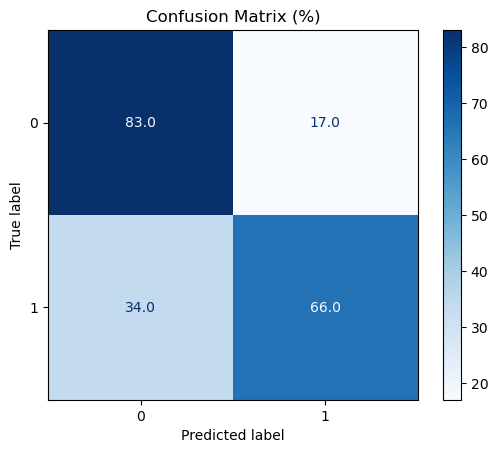

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =========================
# TRAIN FINAL MODEL ON FULL DATA
# =========================
pipeline.fit(X, y)
joblib.dump(pipeline, "PD_MoCA_SVM_SelectedFeatures.pkl")
print("\nFinal SVM model saved as PD_MoCA_SVM_SelectedFeatures.pkl")

# =========================
# CONFUSION MATRIX (Percent)
# =========================
y_pred = pipeline.predict(X)

# Normalize to get percentage per true class
cm_percent = confusion_matrix(y, y_pred, labels=pipeline.classes_, normalize='true') * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=pipeline.classes_)
disp.plot(cmap='Blues', values_format=".1f")  # one decimal place
disp.ax_.set_title("Confusion Matrix (%)")
